<a href="https://colab.research.google.com/github/ukingen/2770406-Robotics-Starter-Kit/blob/master/Traffic_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv("/content/traffic.csv")
data.head()


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [ ]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

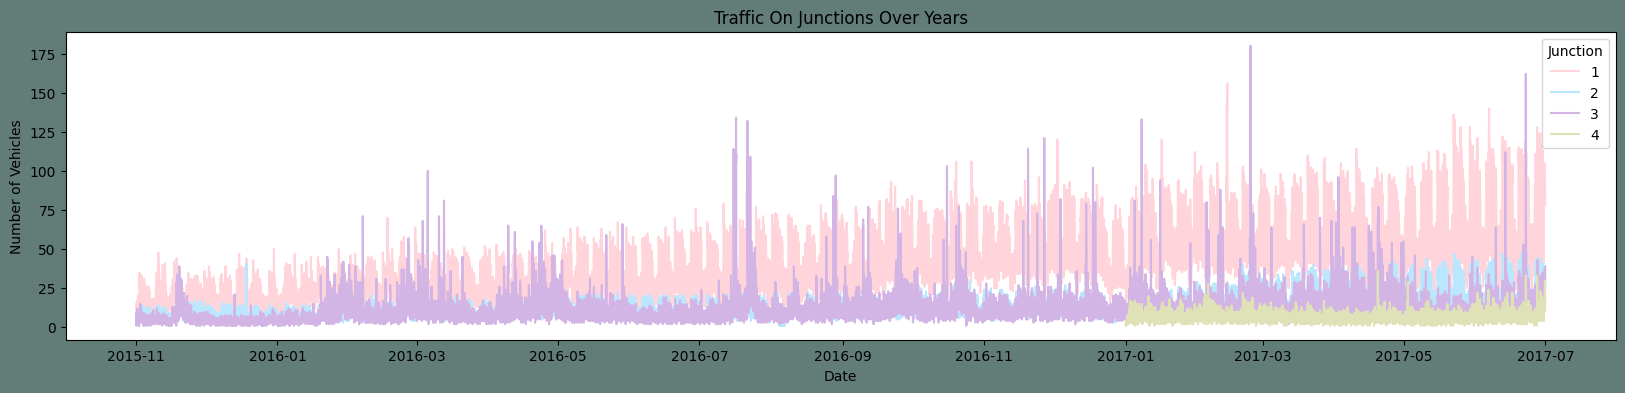

In [ ]:
df=data.copy()

colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [ ]:
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


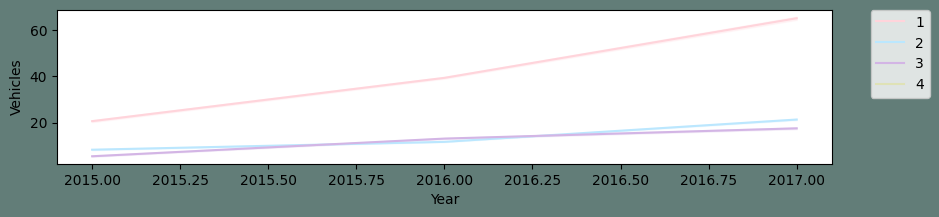

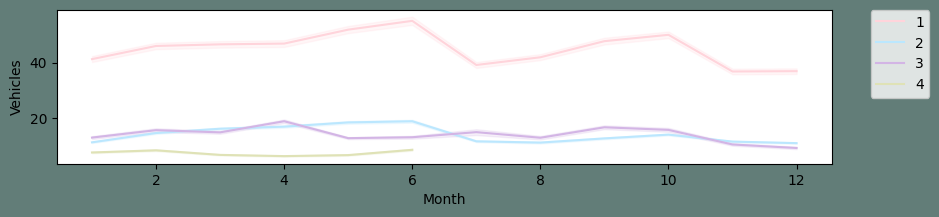

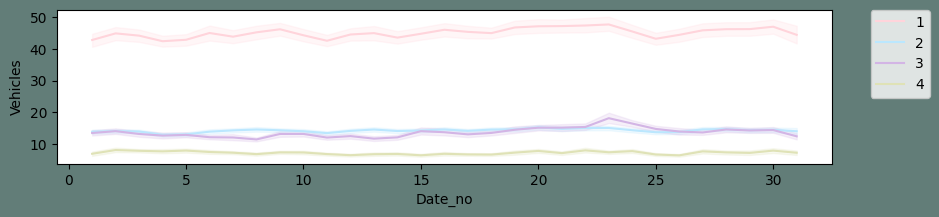

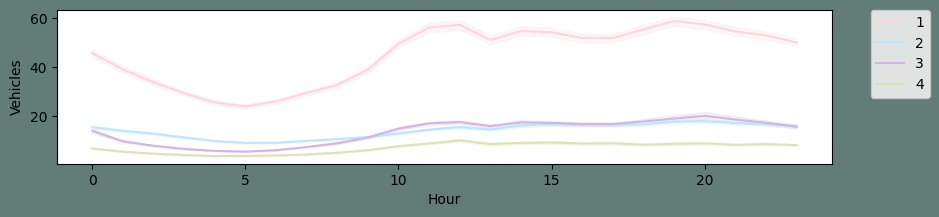

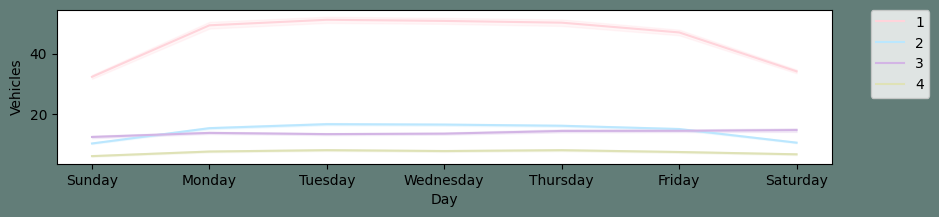

In [ ]:
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,2),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

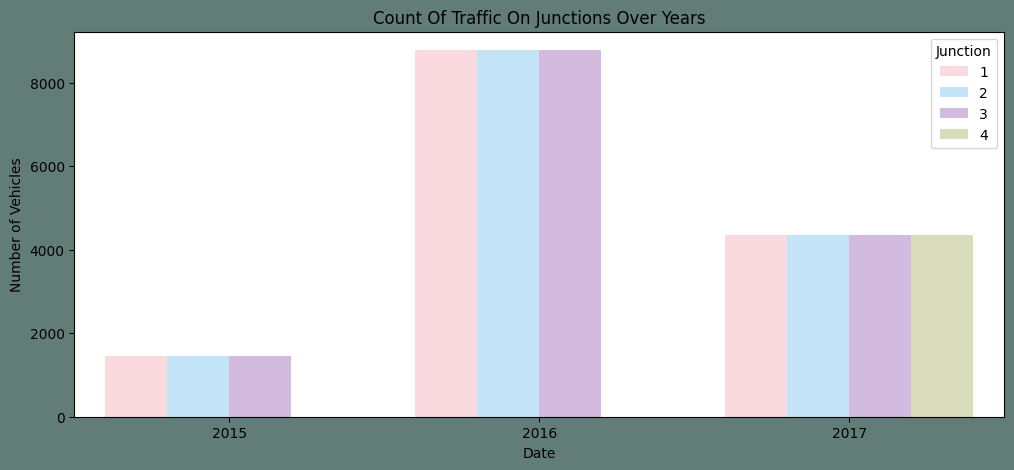

In [ ]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

<Axes: >

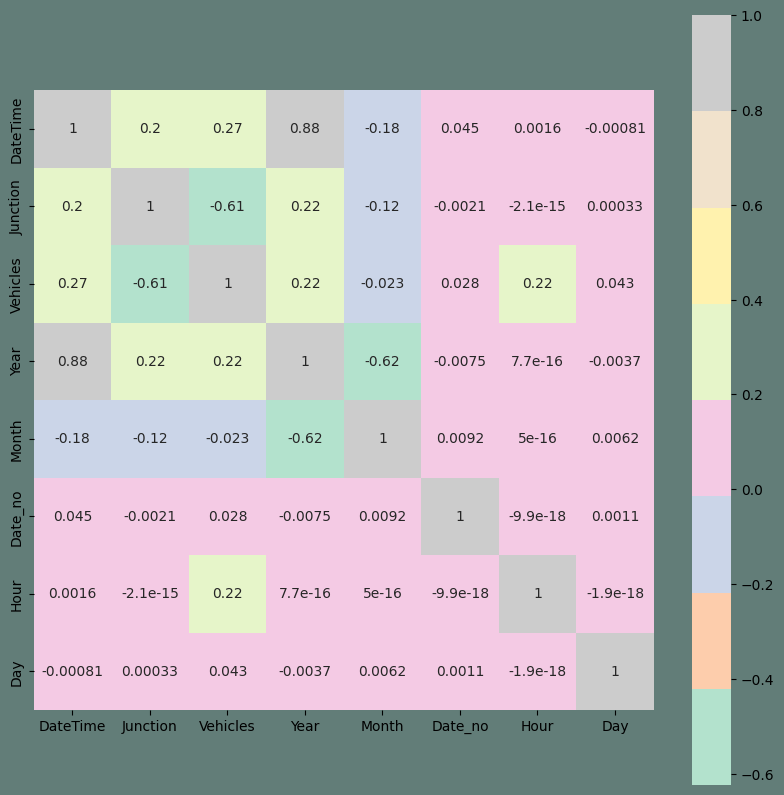

In [ ]:
df["Day"] = df["Day"].astype("category").cat.codes

corrmat = df.corr()
plt.subplots(figsize=(10,10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )

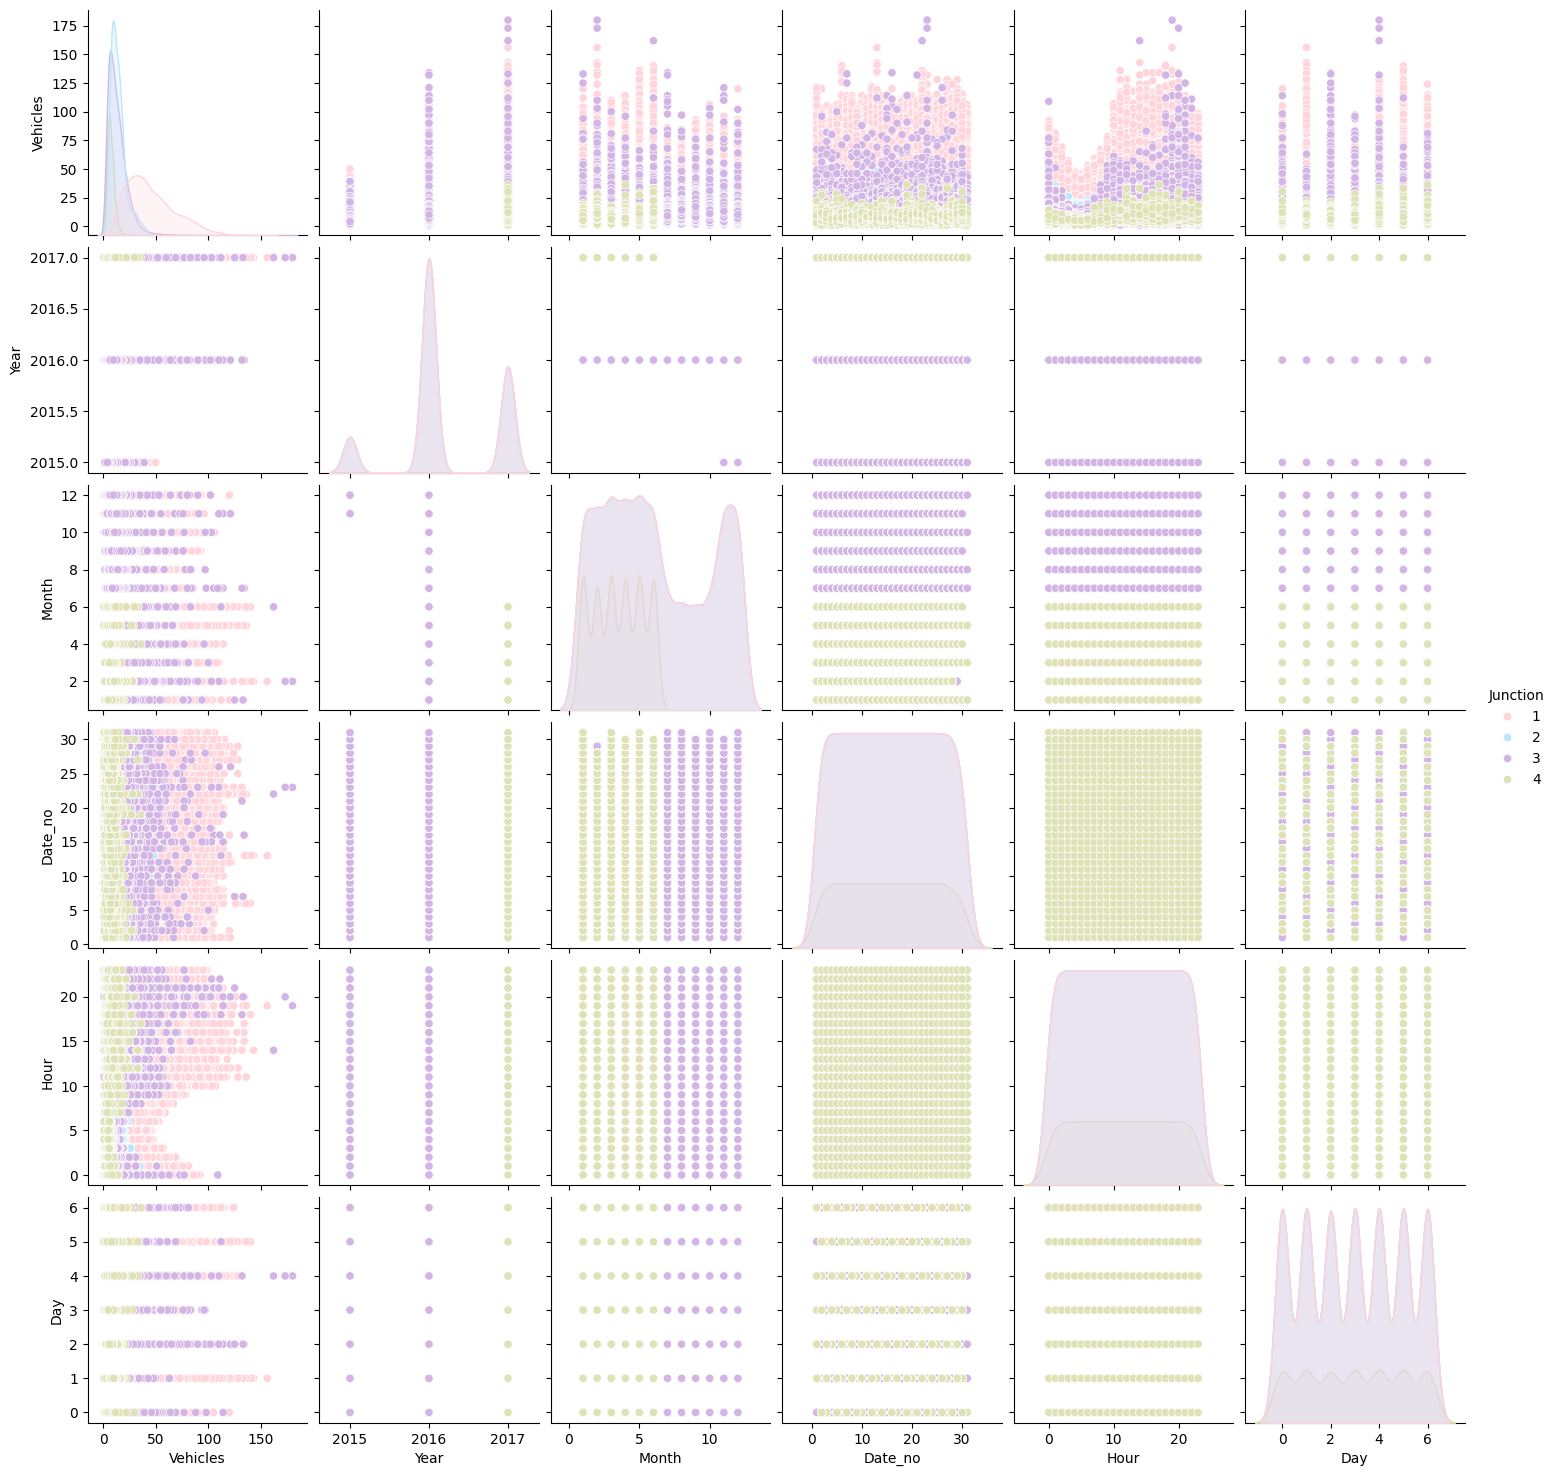

In [ ]:
sns.pairplot(data=df, hue= "Junction",palette=colors)

In [ ]:
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

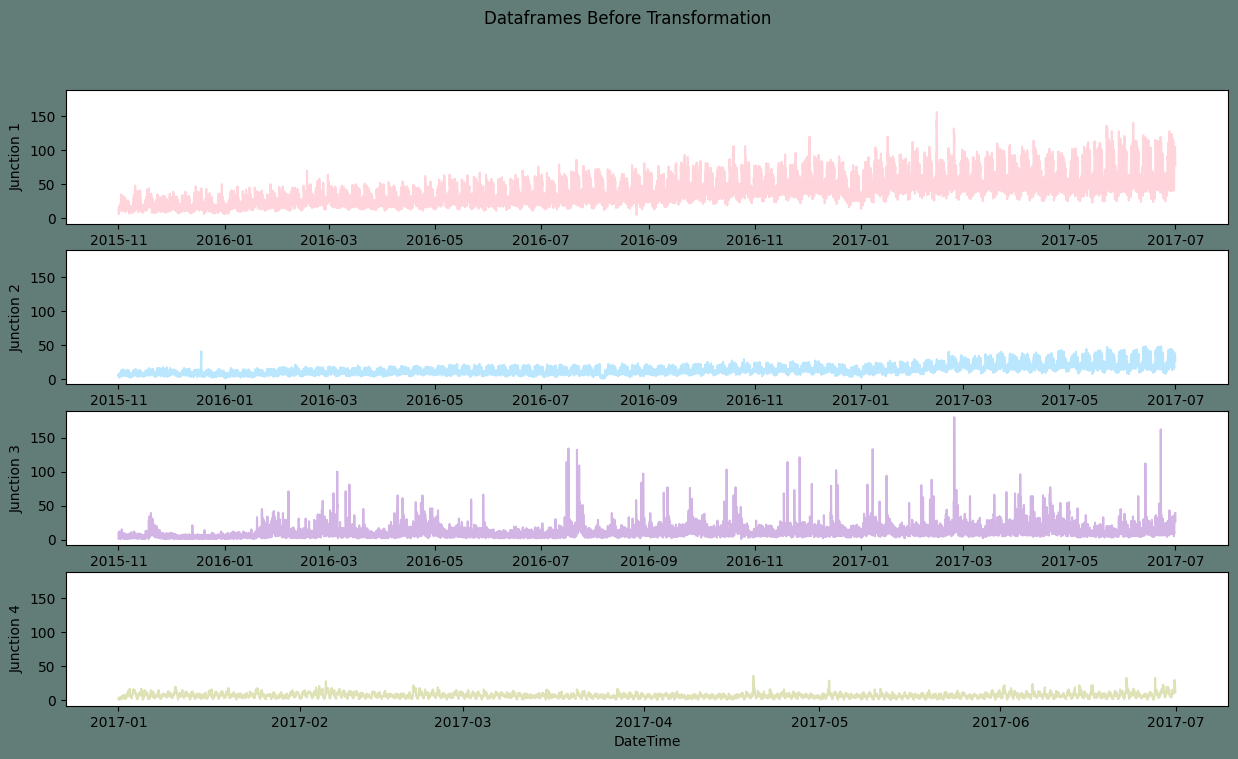

In [ ]:
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna()


list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)


def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)

    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])

    axes[0].set(ylabel ="Junction 1")

    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")

    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")

    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")



Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

In [ ]:
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev


def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [ ]:
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7))
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24))
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1)
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1)
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

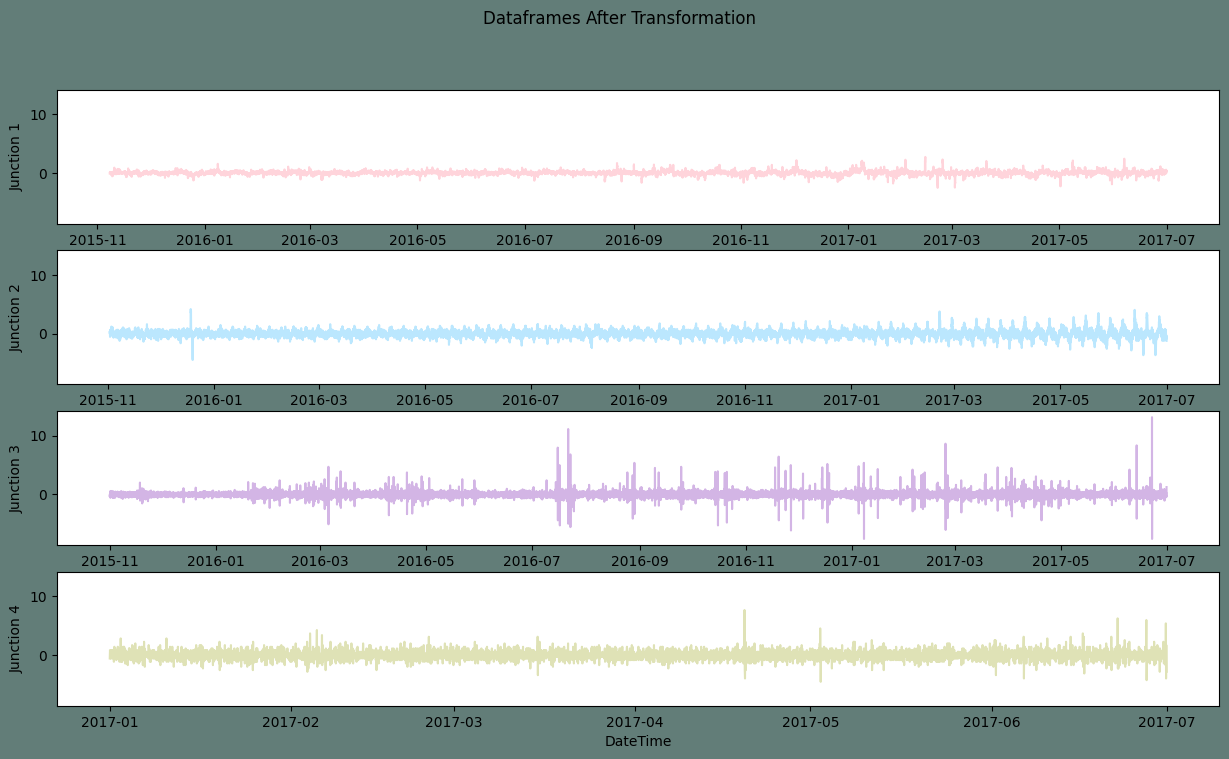

In [ ]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

In [ ]:
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")




List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415337
p-value: 4.79853987639816e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.795891026940065
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832316
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.979092563052276
p-value: 2.778787532595421e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [ ]:
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()


def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test

J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)


def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y


def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test


X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

In [ ]:
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)


    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))


    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    model.compile(optimizer=SGD(learning_rate=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU


def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse


def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [ ]:
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 41s 363ms/step - loss: 0.1019
Epoch 2/50
87/87 [==============================] - ETA: 0s - loss: 0.1020

87/87 [==============================] - 32s 373ms/step - loss: 0.1020
Epoch 3/50
87/87 [==============================] - ETA: 0s - loss: 0.1020

87/87 [==============================] - 31s 354ms/step - loss: 0.1020
Epoch 4/50
87/87 [==============================] - ETA: 0s - loss: 0.1021

87/87 [==============================] - 32s 369ms/step - loss: 0.1021
Epoch 5/50
87/87 [==============================] - ETA: 0s - loss: 0.1020

87/87 [==============================] - 33s 379ms/step - loss: 0.1020
Epoch 6/50
87/87 [==============================] - ETA: 0s - loss: 0.1021

87/87 [==============================] - 33s 379ms/step - loss: 0.1021
Epoch 7/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 32s 372ms/step - loss: 0.1019
Epoch 8/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 33s 375ms/step - loss: 0.1019
Epoch 9/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 31s 357ms/step - loss: 0.1019
Epoch 10/50
87/87 [==============================] - ETA: 0s - loss: 0.1020

87/87 [==============================] - 33s 374ms/step - loss: 0.1020
Epoch 11/50
87/87 [==============================] - ETA: 0s - loss: 0.1020

87/87 [==============================] - 31s 361ms/step - loss: 0.1020
Epoch 12/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 33s 385ms/step - loss: 0.1019
Epoch 13/50
87/87 [==============================] - ETA: 0s - loss: 0.1020

87/87 [==============================] - 31s 358ms/step - loss: 0.1020
Epoch 14/50
87/87 [==============================] - ETA: 0s - loss: 0.1021

87/87 [==============================] - 33s 385ms/step - loss: 0.1021
Epoch 15/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 36s 409ms/step - loss: 0.1019
Epoch 16/50
87/87 [==============================] - ETA: 0s - loss: 0.1022

87/87 [==============================] - 36s 418ms/step - loss: 0.1022
Epoch 17/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 34s 394ms/step - loss: 0.1019
Epoch 18/50
87/87 [==============================] - ETA: 0s - loss: 0.1020

87/87 [==============================] - 33s 383ms/step - loss: 0.1020
Epoch 19/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 34s 390ms/step - loss: 0.1019
Epoch 20/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 33s 378ms/step - loss: 0.1019
Epoch 21/50
87/87 [==============================] - ETA: 0s - loss: 0.1021

87/87 [==============================] - 35s 396ms/step - loss: 0.1021
Epoch 22/50
87/87 [==============================] - ETA: 0s - loss: 0.1020

87/87 [==============================] - 34s 390ms/step - loss: 0.1020
Epoch 23/50
87/87 [==============================] - ETA: 0s - loss: 0.1021

87/87 [==============================] - 32s 368ms/step - loss: 0.1021
Epoch 24/50
87/87 [==============================] - ETA: 0s - loss: 0.1018

87/87 [==============================] - 34s 395ms/step - loss: 0.1018
Epoch 25/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 31s 359ms/step - loss: 0.1019
Epoch 26/50
87/87 [==============================] - ETA: 0s - loss: 0.1020

87/87 [==============================] - 33s 378ms/step - loss: 0.1020
Epoch 27/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 32s 373ms/step - loss: 0.1019
Epoch 28/50
87/87 [==============================] - ETA: 0s - loss: 0.1021

87/87 [==============================] - 33s 379ms/step - loss: 0.1021
Epoch 29/50
87/87 [==============================] - ETA: 0s - loss: 0.1020

87/87 [==============================] - 32s 364ms/step - loss: 0.1020
Epoch 30/50
87/87 [==============================] - ETA: 0s - loss: 0.1020

87/87 [==============================] - 32s 372ms/step - loss: 0.1020
Epoch 31/50
87/87 [==============================] - ETA: 0s - loss: 0.1021

87/87 [==============================] - 32s 366ms/step - loss: 0.1021
Epoch 32/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 39s 445ms/step - loss: 0.1019
Epoch 33/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 36s 413ms/step - loss: 0.1019
Epoch 34/50
87/87 [==============================] - ETA: 0s - loss: 0.1018

87/87 [==============================] - 36s 412ms/step - loss: 0.1018
Epoch 35/50
87/87 [==============================] - ETA: 0s - loss: 0.1020

87/87 [==============================] - 34s 395ms/step - loss: 0.1020
Epoch 36/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 38s 438ms/step - loss: 0.1019
Epoch 37/50
87/87 [==============================] - ETA: 0s - loss: 0.1020

87/87 [==============================] - 36s 419ms/step - loss: 0.1020
Epoch 38/50
87/87 [==============================] - ETA: 0s - loss: 0.1018

87/87 [==============================] - 35s 403ms/step - loss: 0.1018
Epoch 39/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 33s 383ms/step - loss: 0.1019
Epoch 40/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 35s 408ms/step - loss: 0.1019
Epoch 41/50
87/87 [==============================] - ETA: 0s - loss: 0.1018

87/87 [==============================] - 37s 421ms/step - loss: 0.1018
Epoch 42/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 34s 388ms/step - loss: 0.1019
Epoch 43/50
87/87 [==============================] - ETA: 0s - loss: 0.1020

87/87 [==============================] - 36s 419ms/step - loss: 0.1020
Epoch 44/50
87/87 [==============================] - ETA: 0s - loss: 0.1019

87/87 [==============================] - 38s 432ms/step - loss: 0.1019
Epoch 45/50
87/87 [==============================] - ETA: 0s - loss: 0.1020

87/87 [==============================] - 35s 408ms/step - loss: 0.1020
Epoch 46/50
87/87 [==============================] - ETA: 0s - loss: 0.1018

87/87 [==============================] - 34s 393ms/step - loss: 0.1018
Epoch 47/50
87/87 [==============================] - ETA: 0s - loss: 0.1018

87/87 [==============================] - 35s 407ms/step - loss: 0.1018
Epoch 48/50
87/87 [==============================] - ETA: 0s - loss: 0.1018

87/87 [==============================] - 34s 391ms/step - loss: 0.1018
Epoch 49/50
87/87 [==============================] - ETA: 0s - loss: 0.1018

87/87 [==============================] - 34s 389ms/step - loss: 0.1018
Epoch 50/50
87/87 [==============================] - ETA: 0s - loss: 0.1017

45/45 [==============================] - 4s 48ms/step


In [ ]:
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

In [ ]:
PredJ2 = GRU_model(X_trainJ2,y_trainJ2,X_testJ2)

In [ ]:
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

In [ ]:
PredJ3 = GRU_model(X_trainJ3,y_trainJ3,X_testJ3)

In [ ]:
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

In [ ]:
PredJ4 = GRU_model(X_trainJ4,y_trainJ4,X_testJ4)

In [ ]:
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)

In [ ]:
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)

    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")

    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

In [ ]:
recover1 = df_N1.Norm[-1412:-1].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with orignals
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Pridictions And Orignals For Junction 1", 0)

In [ ]:
recover2 = df_N2.Norm[-1426:-1].to_frame() #len as per the diff
recover2["Pred"]= PredJ2
Transform_reverssed_J2 = inverse_difference(recover2.Norm, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* std_J2) + av_J2
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Pridictions And Orignals For Junction 2", 1)

In [ ]:
recover3 = df_N3.Norm[-1429:-1].to_frame() #len as per the diff
recover3["Pred"]= PredJ3
Transform_reverssed_J3 = inverse_difference(recover3.Norm, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* std_J3) + av_J3
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Pridictions And Orignals For Junction 3", 2)

In [ ]:
recover4 = df_N4.Norm[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= PredJ4
Transform_reverssed_J4 = inverse_difference(recover4.Norm, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* std_J4) + av_J4
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Pridictions And Orignals For Junction 4", 3)